# Gold and USD inflation
Using monthly data we will explore the relationship between gold prices and
inflation.

### Inspirations
- [The FRED® Blog: Is gold a good hedge against inflation?]
(https://fredblog.stlouisfed.org/2019/03/is-gold-a-good-hedge-against-inflation/)

### Definitions
- Gold: The ICE Benchmark Administration Limited (IBA), Gold Fixing Price in
the London Bullion Market, based in U.S. Dollars, retrieved from FRED,
Federal Reserve Bank of St. Louis
- CPI inflation: Consumer Price Index, seasonally adjusted monthly since 1947,
, retrieved from FRED, Federal Reserve Bank of St. Louis
- PCE inflation: Personal Consumption Expenditure, seasonally adjusted monthly
since 1959, retrieved from FRED, Federal Reserve Bank of St. Louis
- SYN inflation: Synthetic Inflation, normalized and averaged over CPI,
CPI Core, PCE and PCE Core inflation measures, retrieved from FRED, Federal
Reserve Bank of St. Louis

### Dependencies:
- Python: datetime, fecon236, matplotlib, numpy, pandas, pandas_datareader,
sklearn, statsmodels, sympy, seaborn
- Written using Python 3.8.5, Atom 1.51, Hydrogen 2.14.4


## 0. Preamble: Code Setup and Function Definitions

### Check if required modules are installed in the kernel; and if not install them

In [1]:
import sys
import subprocess
import pkg_resources
required = {'datetime', 'fecon236', 'matplotlib', 'numpy', 'pandas',
            'pandas_datareader', 'sklearn', 'statsmodels', 'sympy', 'seaborn'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                           stdout=subprocess.DEVNULL)

In [2]:
# fecon236 is a useful econometrics python module for access and using U.S.
# Federal Reserve and related data
import fecon236 as fe
fe.system.specs()
#  If a module is modified, automatically reload it:
%load_ext autoreload
%autoreload 2   # Use 0 to disable this feature.

 !:  Code for this project straddles python27 and python3.
 ::  Python 3.8.5
 ::  IPython 7.18.1
 ::  jupyter_core 4.6.3
 ::  jupyter_client 6.1.7
 ::  notebook 6.1.4
 ::  matplotlib 3.3.1
 ::  numpy 1.19.2
 ::  scipy 1.5.2
 ::  statsmodels 0.12.0
 ::  sympy 1.6.2
 ::  pandas 1.1.2
 ::  pandas_datareader 0.9.0
 ::  fecon236 10.8.0
 ::  Repository: git_repo_None tag_None branch_None
 ::  Timestamp: 2020-09-21T19:48:58Z


### Import useful modules for data wrangling

In [3]:
import numpy as np
import math
import datetime as dt

In [4]:
# Will use sklearn and statsmodels for model development and testing
from sklearn import mixture
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import MeanShift, estimate_bandwidth, MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
# from sklearn.datasets import make_blobs
import statsmodels.api as sm

In [5]:
# Notebook dispaly and formatting options
# Represent pandas DataFrames as text; not HTML representation:
import pandas as pd
pd.set_option('display.notebook_repr_html', False)
# Alter Jupyter option for the pretty display of variables
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Import matplotlib and seaborn for plotting
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm   ### CAN WE GET RID OF THIS WITH SEABORN
#  Generate plots inside notebook, "inline" generates static png
%matplotlib inline
# Use seaborn for to make matplotlib pretty and set the default theme styles
import seaborn as sns
sns.set_theme()
sns.set_style("whitegrid")

### Define Custom Functions

In [6]:
def getaxes(snsplt):
    """Returns list of matpotlib axes objects

    Parameters
    ----------
    snsplt : seaborn plot
        A reference to a seaborn plot that contains the axes

    Returns
    -------
    [matplotlib.axes._subplots.AxesSubplot]
        A list of axes objects
    """

    # If only one plot, then snsplt.axes is a list of lists, so addressable
    # via snsplt.axes[0][0]
    if type(snsplt.axes[0]) == np.ndarray:
            axobjs = snsplt.axes[0]
    # If multiple plots, then it is a list of objects, so addressable via
    # snsplt.axes[0]
    else:
        axobjs = snsplt.axes

    return axobjs

In [7]:
def fmtticks(fmt, fmt0, ticks, tickscle, tickscle0):
    """Formats x and y axis tick labels for a seaborn plot

    Parameters
    ----------
    fmt : str
        The formatting string to use for all tick labels
    fmt0 : str
        The formatting string to use for only the first tick label
    ticks : numpy.ndarray
        1D array of tick labels to format
    tickscle  : float, optional
        Scale factor to apply to all tick labels e.g. if format string
        is for a %, and the labels are in the range 0 to 100,
        then numscle = 0.01 to change the range to 0 to 1
    tickscle0 : float, optional
        Scale factor to apply to only the first tick label

    Returns
    -------
    list of str
        List of formatted tick labels in string format
    """

    tick0 = ticks[0]
    lbls = [fmt.format(tick * tickscle) for tick in ticks]
    lbl0 = fmt0.format(tick0 * tickscle0)
    lbls[0] = lbl0
    return lbls

In [8]:
def frmtaxislbls(snsplt, fmt: str='{:.0}', fmt0: str=':.0%',
                 axis: str='x', tickscle: float=1.0, tickscle0: float=1.0):
    """Formats x and y axis tick labels for each axis on a seaborn plot

    Parameters
    ----------
    snsplt : seaborn plot
        A reference to a seaborn plot that contains the axis labels for
        formatting
    fmt : str, optional
        The formatting string to use for all tick labels
    fmt0 : str, optional
        The formatting string to use for only the first tick label
    axis : str, optional
        Which axis to format, 'x' for horizontal, 'y' for vertical
    numscle : float, optional
        Scale factor to apply to all tick labels e.g. if format string
        is for a %, and the labels are in the range 0 to 100,
        then numscle = 0.01 to change the range to 0 to 1
    numscle0 : float, optional
        Scale factor to apply to only the first tick label

    Returns
    -------
    Null
    """

    axobjs = getaxes(snsplt)
    if axis == 'x':
        for ax in axobjs:
            ticks = ax.get_xticks()
            lbls = fmtticks(fmt, fmt0, ticks, tickscle, tickscle0)
            snsplt.set_xticklabels(lbls)
    elif axis == 'y':
        for ax in axobjs:
            ticks = ax.get_yticks()
            lbls = fmtticks(fmt, fmt0, ticks, tickscle, tickscle0)
            snsplt.set_yticklabels(lbls)

    return

In [9]:
def snslmplot(data: pd.core.frame.DataFrame, xcol: str, ycol: str,
              yidcol: str=None, degree: int=1, col_wrap: int=None,
              title: str=None, axistitles: str=None):
    """Draws plot from data input with polynomial of order degree

    Parameters
    ----------
    data : panda DataFrame
        Panda melted data frame containing the data, m rows by 3 columns
        The three columns are identified by the xcol, idcol, datacol function
        parameters - see below
    xcol : str
        The name of the DataFrame column that contains data for the independent
        variable i.e. x
    ycol : str
        The name of the DataFrame colum that contains the y data
    yidcol : str, optional
        The name of the DataFrame column that contains data identifying the y
        data to select. For example, if the data has been melted from two
        variables 'y1' and 'y2', this column would contain either 'y1' or 'y2'
        to identify which rows pertain to the relevant y variable
    degree : int, optional
        The polynomial degree definition e.g. 2 for a quadractic polynomial
    col_wrap : int, optional
        The number of facets to display per row i.e. wrap on
    title : str, optional
        Title to include on the chart; can also be a list of strings
    axistitles : str, optional
        Title for each of the titles, x-axis first, y-axis second

    Returns
    -------
    FacetGrid
        The FacetGrid generated by seaborn
    """
    snsfctgrid = sns.lmplot(data=data, x=xcol, y=ycol, col=yidcol, order=degree,
                        col_wrap=col_wrap, aspect=1.333, palette="muted")
    snsfctgrid.despine(left=True)
    frmtaxislbls(snsfctgrid, fmt='{:.2f}', fmt0='{:.2%}', axis='x',
                 tickscle=1, tickscle0=0.01)
    frmtaxislbls(snsfctgrid, fmt='{:.1f}', fmt0='{:.1%}', axis='y',
                 tickscle=1, tickscle0=0.01)
    plt.subplots_adjust(wspace = 0.1)
    return snsfctgrid

In [10]:
def defnmodel(data: pd.core.frame.DataFrame, degree: int=1):
    """Defines a polynomial model for data x and y of order degree using
    ordinary least squares regression based

    Parameters
    ----------
    data : panda DataFrame
        Panda data frame containing the data, m rows by 2 columns with the
        first column containing the indepedent variable (i.e. x) and the second
        column containing the dependent variable (i.e. y)
    degree : int, optional
        The polynomial degree definition e.g. 1 for linear, 2 for a
        quadractic polynomial

    Returns
    -------
    xp : numpy array
        array of degree columns containing the polynomial features e.g. for a 2
        degree polynomial, features are [1, a, b, a^2, ab, b^2]
    yarray : numpy array
        array of dependent variable data
    modelresults : sm ols model fit results
        orindary least squares regression model produced by statsmodels with
        results
    poly1d_fn : numpy poly1d
        the polynomial definition e.g. x**2 + 2*x + 3
    """

    xcol = 0
    ycol = 1
    polyFeatures = PolynomialFeatures(degree) # Define the polynomial
    # Reshape data from 1 by n to n by 1
    xarray = np.array(data.iloc[:, xcol])
    xarray = xarray[:, np.newaxis]

    # Calculate polynomials for x
    xp = polyFeatures.fit_transform(xarray)

    # Reshape y from 1 by n to n by 1
    yarray = np.array(data.iloc[:, ycol])
    yarray = yarray[:, np.newaxis]

    # Calculate the model and predictions
    modelresults = sm.OLS(yarray, xp).fit()
    coef = modelresults.params.tolist()    # Model coefficients
    coef.reverse()                  # Reverse as poly1d takes in decline order
    poly1d_fn = np.poly1d(coef)     # Create function from coefficients

    return xp, yarray, modelresults, poly1d_fn

In [11]:
def dispmodel(data: pd.core.frame.DataFrame, degree: int=1):
    """Displays summary statistics and regression results for polynomial model
    or order 'degree'

    Parameters
    ----------
    data : panda DataFrame
        Panda data frame containing the data, m rows by 2 columns with the
        first column containing the indepedent variable (i.e. x) and the second
        column containing the dependent variable (i.e. y)
    degree : int, optional
        The polynomial degree definition e.g. 1 for linear, 2 for a
        quadractic polynomial

    Returns
    -------
    Null
    """
    xcol = 0
    ycol = 1

    xp, yarray, modelresults, poly1d_fn = defnmodel(data, degree)
    print(" ::  FIRST variable (x):")
    print(data.iloc[:, xcol].describe(), '\n')
    print(" ::  SECOND variable (y):")
    print(data.iloc[:, ycol].describe(), '\n')
    print(modelresults.summary())

    return

## 1. Retrieve Data, Determine Appropiate Start and End Dates for Analysis

In [12]:
# Get gold and inflation rates, both as monthly frequency
# Notes: fecon236 uses median to resample (instead of say mean) and also
# replaces FRED empty data (marked with a ".") with data from previously
# occuring period; These adjustments will drive some small differences to
# the analysis on th FRED blog
# Daily London AM gold fix, nominal USD, converted to monthly
gold_usdnom = fe.monthly(fe.get('GOLDAMGBD228NLBM'))
# Daily London PM gold fix, nominal USD, converted to monthly
# gold_usdnom = fe.get(fe.m4xau)
# Percentage calcualtion for month on month i.e. frequency = 1
freq = 1
gold_usdnom_pc = fe.nona(fe.pcent(gold_usdnom, freq))

In [13]:
# Inflation in use
infcode = fe.m4cpi      # FRED code 'CPIAUCSL'
# infcode = fe.m4pce    # FRED code 'PCEPI'
# Synthetic average of 'CPIAUCSL', 'CPILFESL', 'PCEPI', 'CPILFESL'
# infcode = fe.m4infl
infidx = fe.get (fe.m4cpi)        # Returns the index, not percentage change
inf_pc = fe.nona(fe.pcent(infidx, freq))

In [14]:
# Gold with USD inflation removed i.e. in real USD
# First, calculate rebased inflation index
inf_basedate = '2020-08-01'              # The base date for our index
inf_base = infidx['Y'][inf_basedate]
infidx_rebased = fe.div(infidx, inf_base)

In [15]:
# Find the first and last overlapping dates for the two data series where
# we are using values
startv = max(fe.head(gold_usdnom, 1).index[0], fe.head(infidx, 1).index[0])
endv = min(fe.tail(gold_usdnom, 1).index[0], fe.tail(infidx, 1).index[0])

In [16]:
# Calculate the real gold price
gold_usdrl = fe.div(gold_usdnom.loc[startv:endv],
                    infidx_rebased.loc[startv:endv])
gold_usdrl_pc = fe.nona(fe.pcent(gold_usdrl, freq))

In [17]:
# Find the first and last overlapping dates for the two data series where we
# are using month on month percentage change
startpc = max(fe.head(gold_usdrl_pc, 1).index[0], fe.head(inf_pc, 1).index[0])
endpc = min(fe.tail(gold_usdrl_pc, 1).index[0], fe.tail(inf_pc, 1).index[0])

## 2. Plot and Review Time Series of Monthly Inflation and Gold Price Levels

In [18]:
# TODO: Plot time series charts: nominal au in USD vs inf index, real au in USD vs inf index

In [19]:
# TODO: Plot time series charts: change in: nominal au vs inf, real au vs inf

## 3. Plot and Review Change in Inflation and Gold Price Levels
### 3.1 Monthly Data

In [20]:
# Nominal USD data
mom_npc = pd.concat([inf_pc[startpc:endpc],
                    gold_usdnom_pc[startpc:endpc]], axis=1)
inf_pc_colnm = 'Monthly Change in Inflation'
gold_usdnom_pc_colnm = 'Monthly Change in Gold Price (Nom. USD)'
mom_npc.columns = [inf_pc_colnm, gold_usdnom_pc_colnm]

In [21]:
# Real USD data
mom_rpc = pd.concat([inf_pc[startpc:endpc],
                     gold_usdrl_pc[startpc:endpc]], axis=1)
gold_usdrl_pc_colnm = 'Monthly Change in Gold Price (Real USD)'
mom_rpc.columns = [inf_pc_colnm, gold_usdrl_pc_colnm]

In [22]:
# *Melt* the data together so we can display the charts side-by-side
mom_pc = mom_npc.join(mom_rpc.loc[:, mom_rpc.columns != inf_pc_colnm],
                      how='inner', sort=True)
mom_pc = pd.melt(mom_pc,
                 id_vars=inf_pc_colnm,
                 value_vars=[gold_usdnom_pc_colnm, gold_usdrl_pc_colnm])
norrl_colnm = 'Nominal or Real'
aupc_colnm = 'Monthly Change in Gold Price'
mom_pc.columns = [inf_pc_colnm,
                  norrl_colnm, aupc_colnm]

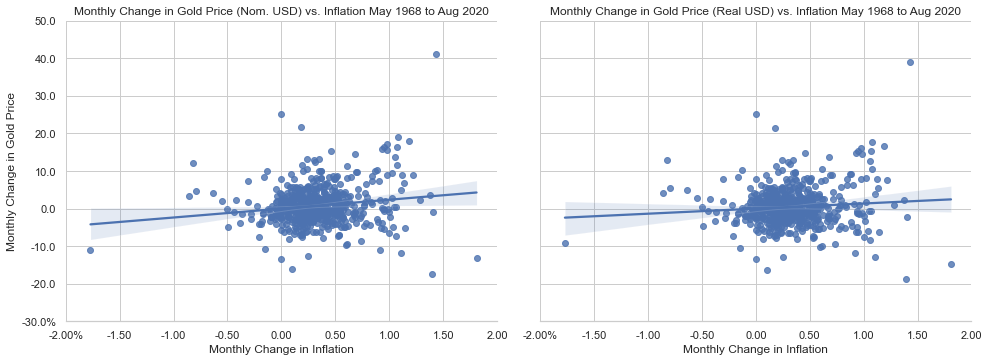

In [23]:
# Display the charts
snsfcg_mom = snslmplot(data=mom_pc, xcol=inf_pc_colnm, ycol=aupc_colnm,
                       yidcol=norrl_colnm, degree=1, col_wrap=2)
mom_pc_title_tmplte = ' vs. Inflation {} to {}'
mom_pc_title_tmplte =  mom_pc_title_tmplte.format(startpc.strftime("%b %Y"),
                                                  endpc.strftime("%b %Y"))
snsfcg_mom = snsfcg_mom.set_titles(col_template="{col_name}" + mom_pc_title_tmplte)

2020-09-15: The regression analysis shows a relationship
(t-stat 2.245), with a 1% increase in inflation having a 1.3573% increase in
the real price of gold. However, the adj. r-squared is only 0.006, indicating
there are many other factors at play that influence the change in gold prices.
2020-09-15: The regression analysis shows a strong relationship
(t-stat 3.896), however we need to remove the inflation contained in the
nominal gold price

### 3.2 Yearly Data

In [24]:
# Change percentage calcualtion to every 12 months
freq = 12
gold_usdrl_apc = fe.nona(fe.pcent(gold_usdrl, freq))
inf_apc = fe.nona(fe.pcent(infidx, freq))

In [25]:
# Find the first and last overlapping dates for the two data series
startapc = max(fe.head(gold_usdrl_apc, 1).index[0], fe.head(inf_apc, 1).index[0])
endapc = min(fe.tail(gold_usdrl_apc, 1).index[0], fe.tail(inf_apc, 1).index[0])

In [26]:
# Show same analysis as above
yoy_rpc = pd.concat([inf_apc[startapc:endapc],
                     gold_usdrl_apc[startapc:endapc]], axis=1)
inf_apc_colnm = 'Yearly Inflation'
gold_usdrl_apc_colnm = 'Yearly Change in Gold Price (Real USD)'
yoy_rpc.columns = [inf_apc_colnm, gold_usdrl_apc_colnm]

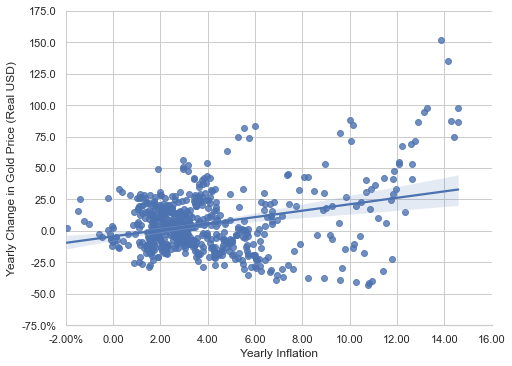

In [27]:
# Display the chart
snsfcg_yoy = snslmplot(data=yoy_rpc, xcol=inf_apc_colnm,
                       ycol=gold_usdrl_apc_colnm, degree=1)
yoy_pc_title_tmplte = ' vs. Inflation {} to {}'
yoy_pc_title_tmplte =  yoy_pc_title_tmplte.format(startapc.strftime("%b %Y"),
                                                  endapc.strftime("%b %Y"))
snsfcg_yoy = snsfcg_yoy.set_titles(col_template="{col_name}" + yoy_pc_title_tmplte)

2020-09-15: The regression analysis shows a relationship
(t-stat 8.119), with a 1% increase in inflation having a 2.5554% increase in
the real price of gold; the adj. r-squared has increased slightly to 0.095, so
still many other factors at play in determing the gold price

Another way to consider this is, yes gold may hedge inflation, but with so
many other (so far unknown) factors impacting the price of gold, there is lot
of risk in using gold to purely hedge inflation

Potentially there is greater movement in the gold price when the inflation
change is > ~8%

### 3.3 Yearly Data with Higher Order Polynomials

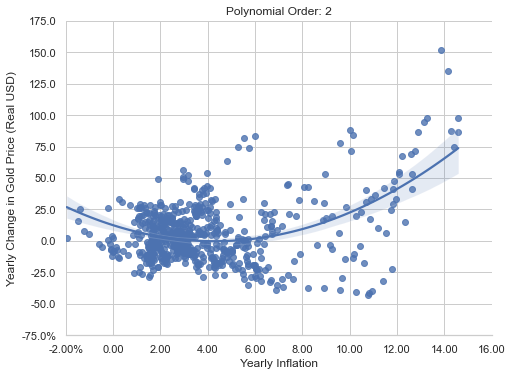

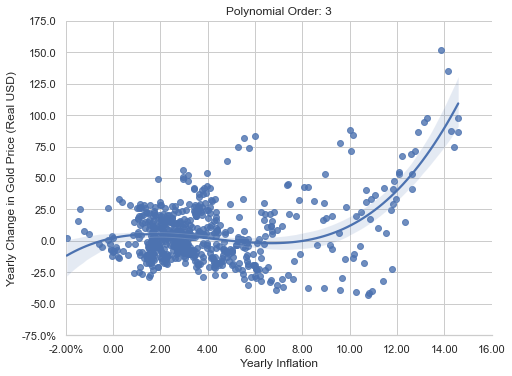

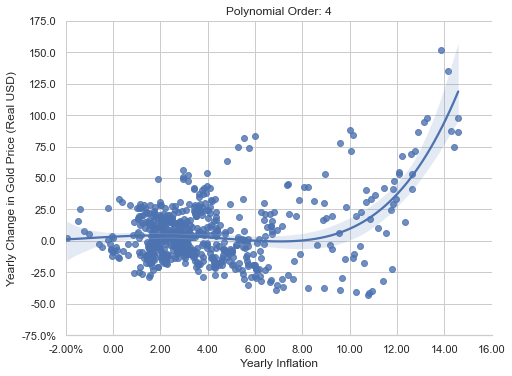

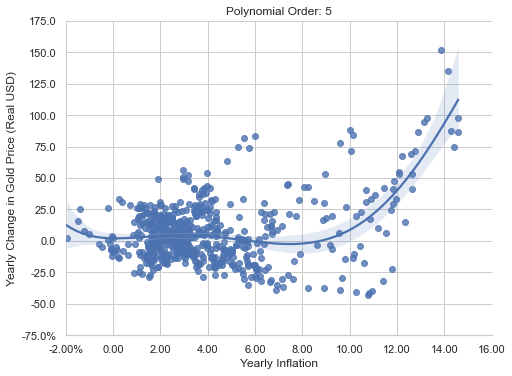

In [28]:
for deg in range(2, 6):
    snsfcg_yoy = snslmplot(data=yoy_rpc, xcol=inf_apc_colnm,
                           ycol=gold_usdrl_apc_colnm, degree=deg)
    for ax in snsfcg_yoy.axes.flat:
        gax = ax.set_title('Polynomial Order: {0}'.format(deg))

In [29]:
# TODO: Change plotting method so that each plot is a subplot..use custom
# function with map? ref: https://seaborn.pydata.org/generated/seaborn.FacetGrid.html

2020-09-15: For `degree = 2` We show a stronger relationship (higher t-stats
and adj. r-squared of 0.212), however it is not clear why a quadractic
equation is an appropiate relationship between inflation and gold prices

2020-09-15: For `degree = 3`, relationship is weaker and not interesting

2020-09-15: For `degree = 4`, relationship is even weaker and not interesting

2020-09-15: For `degree = 5`, now relationships are unidentifiable

## 4 Cluster Analysis

In [30]:
# Create NumPy array to hold data
apc_npa = np.column_stack((inf_apc['Y'][startapc:endapc], gold_usdrl_apc['Y'][startapc:endapc]))

### 4.1 Expectation-Maximization

In [31]:
# fit a GMM
n_components = 3
gmmmdl = mixture.GaussianMixture(n_components=n_components, covariance_type='full')
gmmmdl.fit(apc_npa)
# display predicted scores by the model as a contour plot
xln = np.linspace(math.floor(min(apc_npa[:, 0])), math.ceil(max(apc_npa[:, 0])))
yln = np.linspace(math.floor(min(apc_npa[:, 1])), math.ceil(max(apc_npa[:, 1])))
Xln, Yln = np.meshgrid(xln, yln)
XX = np.array([Xln.ravel(), Yln.ravel()]).T
Zln = -gmmmdl.score_samples(XX)
Zln = Zln.reshape(Xln.shape)

GaussianMixture(n_components=3)

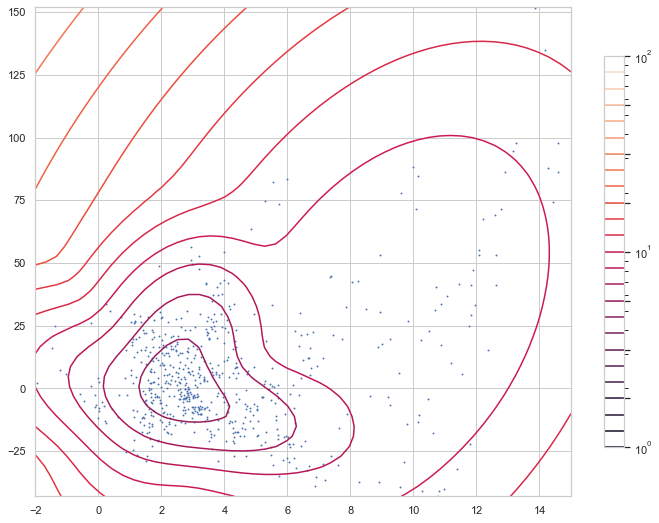

In [32]:
# Create and dsiplay the plot
fig = plt.figure(figsize=(12, 9))
CS = plt.contour(Xln, Yln, Zln, norm=LogNorm(vmin=1, vmax=100.0),
                 levels=np.logspace(0, 2, 25));
CB = plt.colorbar(CS, shrink=0.8);
plt.scatter(apc_npa[:, 0], apc_npa[:, 1], .8);
plt.show()

2020-09-15: For `n_components = 2`, GMM essentially places a high likliehood
around the cluster of data centered on [3, 0] and doesn't pay much attention
to the rest. Not until `n_components ~ 10` does GMM lend any importance to
the data points in the upper left i.e. where this is a high change in
inflation and gold prices

### 4.2 K-Means

In [33]:
# Compute the clustering with k-means
n_clusters = 4
apc_kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10).fit(apc_npa)
k_means_cluster_centers = apc_kmeans.cluster_centers_
k_means_labels = pairwise_distances_argmin(apc_npa, k_means_cluster_centers)

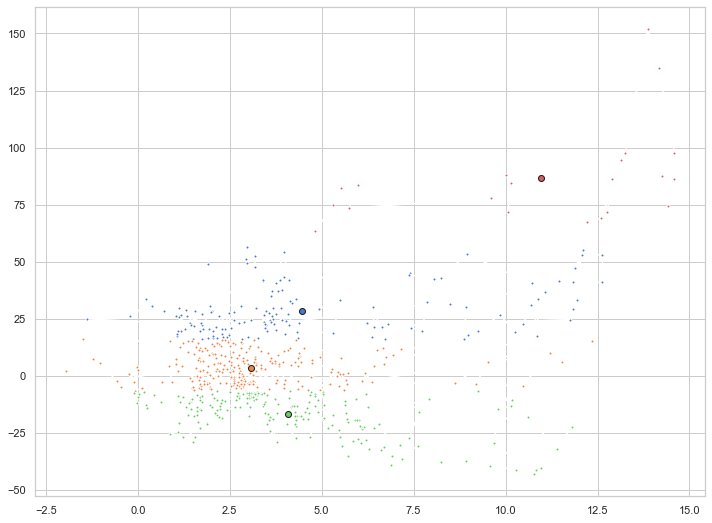

In [34]:
# Plot the results
# colors = tableau20
colors = sns.color_palette('muted')
g = plt.figure(figsize=(12, 9))
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    g = plt.plot(apc_npa[my_members, 0], apc_npa[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    g = plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)

2020-09-15: For `n_clusters = 2`, k-means splits the data essentially along
horizontal axis, seperating when the gold price change into two halves of
when it is positive vs. negative. For `n_clusters = 3`, the data is further
disected along a horizontal line for gold change at approx 50%. A similar
trend occurs for `n_clusters = 4` with a furhter horizontal bisection. In
summary, it is not obvious that horizontal clustering provides any insight
into the gold vs. inflation relationship

### 4.3 OPTICS

In [35]:
# Define fit parameters
clust = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)
# Run the fit
clust.fit(apc_npa)
eps = 2.0
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=eps)

OPTICS(min_cluster_size=0.05)

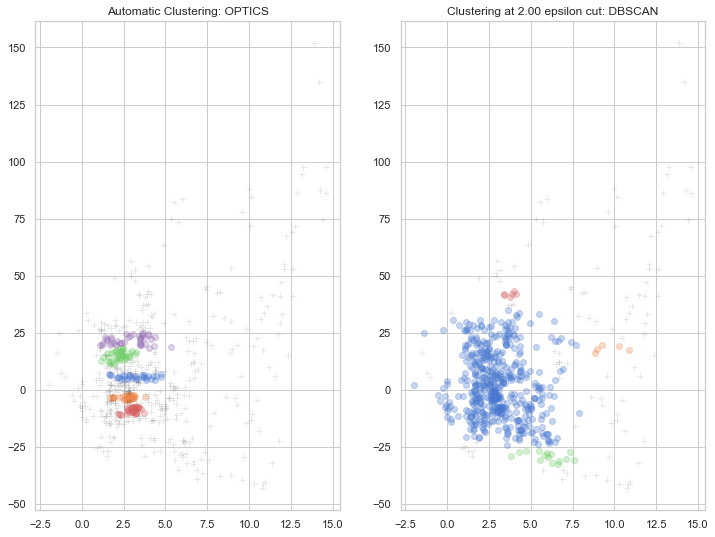

In [36]:
# Create and dsiplay the plot using OPTICS
fit = plt.figure(figsize=(12, 9))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
for klass, color in zip(range(0, 5), colors):
    apc_npak = apc_npa[clust.labels_ == klass]
    g = ax1.plot(apc_npak[:, 0], apc_npak[:, 1], color=color, marker='o',
             ls='', alpha=0.3);

g = ax1.plot(apc_npa[clust.labels_ == -1, 0],
         apc_npa[clust.labels_ == -1, 1], 'k+', alpha=0.1);
title = ax1.set_title('Automatic Clustering: OPTICS')
# plt.show()
# DBSCAN at eps=2.
for klass, color in zip(range(0, 4), colors):
    apc_npak = apc_npa[labels_200 == klass]
    g = ax2.plot(apc_npak[:, 0], apc_npak[:, 1], color=color, marker='o',
             ls='', alpha=0.3)
g = ax2.plot(apc_npa[labels_200 == -1, 0], apc_npa[labels_200 == -1, 1],
         'k+', alpha=0.1);
title = 'Clustering at {0:.2f} epsilon cut: DBSCAN'.format(eps)
g = ax2.set_title(title)
plt.show()

2020-09-15: So similar to previous methods, clustering appears as horizontal
bisections

### 4.4 Mean-Shift (MS)

In [37]:
# Calculate the MS
bandwidth = estimate_bandwidth(apc_npa, quantile=0.25)
apc_ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
apc_ms.fit(apc_npa)
labels = apc_ms.labels_
cluster_centers = apc_ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

MeanShift(bandwidth=12.903426858556879, bin_seeding=True)

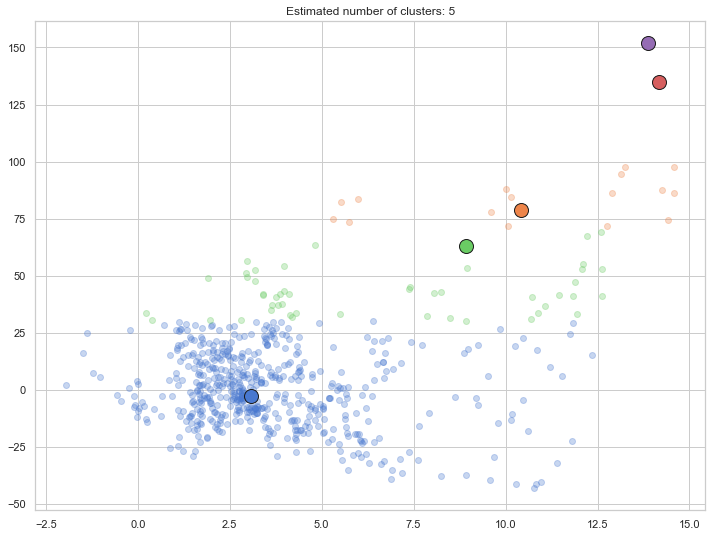

In [38]:
# Plot result
fig = plt.figure(figsize=(12, 9));
for k, color in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    g = plt.plot(apc_npa[my_members, 0], apc_npa[my_members, 1], color=color,
             marker='o', ls='', alpha=0.3)
    g = plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=color,
             markeredgecolor='k', markersize=14)
title = plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

2020-09-15: And so the same story continues, clustering appears as horizontal
bisections

## Appendicies
### A.1 Inflation vs. nominal gold prices, monthly, polynomial order = 1

In [39]:
dispmodel(mom_npc)

 ::  FIRST variable (x):
count    628.000000
mean       0.322930
std        0.327145
min       -1.770548
25%        0.162930
50%        0.273329
75%        0.479044
max        1.809955
Name: Monthly Change in Inflation, dtype: float64 

 ::  SECOND variable (y):
count    628.000000
mean       0.750519
std        5.037336
min      -17.549793
25%       -1.839252
50%        0.081305
75%        2.663181
max       41.120278
Name: Monthly Change in Gold Price (Nom. USD), dtype: float64 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     15.18
Date:                Mon, 21 Sep 2020   Prob (F-statistic):           0.000108
Time:                        15:49:05   Log-Likelihood:                -1898.5
No. Observations:                 628  

### A.2 Inflation vs. real gold prices, monthly, polynomial order = 1

In [40]:
dispmodel(mom_rpc)

 ::  FIRST variable (x):
count    628.000000
mean       0.322930
std        0.327145
min       -1.770548
25%        0.162930
50%        0.273329
75%        0.479044
max        1.809955
Name: Monthly Change in Inflation, dtype: float64 

 ::  SECOND variable (y):
count    628.000000
mean       0.424768
std        4.969401
min      -18.682068
25%       -2.101499
50%       -0.149381
75%        2.375664
max       39.130120
Name: Monthly Change in Gold Price (Real USD), dtype: float64 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     5.038
Date:                Mon, 21 Sep 2020   Prob (F-statistic):             0.0251
Time:                        15:49:05   Log-Likelihood:                -1894.9
No. Observations:                 628  

### A.3 Inflation vs. real gold prices, yearly, polynomial order = 1

In [41]:
dispmodel(mom_npc)

 ::  FIRST variable (x):
count    628.000000
mean       0.322930
std        0.327145
min       -1.770548
25%        0.162930
50%        0.273329
75%        0.479044
max        1.809955
Name: Monthly Change in Inflation, dtype: float64 

 ::  SECOND variable (y):
count    628.000000
mean       0.750519
std        5.037336
min      -17.549793
25%       -1.839252
50%        0.081305
75%        2.663181
max       41.120278
Name: Monthly Change in Gold Price (Nom. USD), dtype: float64 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     15.18
Date:                Mon, 21 Sep 2020   Prob (F-statistic):           0.000108
Time:                        15:49:05   Log-Likelihood:                -1898.5
No. Observations:                 628  

### A.4 Inflation vs. real gold prices, yearly, polynomial order = 2

In [42]:
dispmodel(mom_npc, degree=2)

 ::  FIRST variable (x):
count    628.000000
mean       0.322930
std        0.327145
min       -1.770548
25%        0.162930
50%        0.273329
75%        0.479044
max        1.809955
Name: Monthly Change in Inflation, dtype: float64 

 ::  SECOND variable (y):
count    628.000000
mean       0.750519
std        5.037336
min      -17.549793
25%       -1.839252
50%        0.081305
75%        2.663181
max       41.120278
Name: Monthly Change in Gold Price (Nom. USD), dtype: float64 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     7.726
Date:                Mon, 21 Sep 2020   Prob (F-statistic):           0.000485
Time:                        15:49:05   Log-Likelihood:                -1898.3
No. Observations:                 628  

### A.5 Inflation vs. real gold prices, yearly, polynomial order = 3

In [43]:
dispmodel(mom_npc, degree=3)

 ::  FIRST variable (x):
count    628.000000
mean       0.322930
std        0.327145
min       -1.770548
25%        0.162930
50%        0.273329
75%        0.479044
max        1.809955
Name: Monthly Change in Inflation, dtype: float64 

 ::  SECOND variable (y):
count    628.000000
mean       0.750519
std        5.037336
min      -17.549793
25%       -1.839252
50%        0.081305
75%        2.663181
max       41.120278
Name: Monthly Change in Gold Price (Nom. USD), dtype: float64 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     5.216
Date:                Mon, 21 Sep 2020   Prob (F-statistic):            0.00146
Time:                        15:49:05   Log-Likelihood:                -1898.2
No. Observations:                 628  

### A.6 Inflation vs. real gold prices, yearly, polynomial order = 4

In [44]:
dispmodel(mom_npc, degree=4)

 ::  FIRST variable (x):
count    628.000000
mean       0.322930
std        0.327145
min       -1.770548
25%        0.162930
50%        0.273329
75%        0.479044
max        1.809955
Name: Monthly Change in Inflation, dtype: float64 

 ::  SECOND variable (y):
count    628.000000
mean       0.750519
std        5.037336
min      -17.549793
25%       -1.839252
50%        0.081305
75%        2.663181
max       41.120278
Name: Monthly Change in Gold Price (Nom. USD), dtype: float64 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     8.168
Date:                Mon, 21 Sep 2020   Prob (F-statistic):           2.01e-06
Time:                        15:49:05   Log-Likelihood:                -1889.9
No. Observations:                 628  

### A.7 Inflation vs. real gold prices, yearly, polynomial order = 5

In [45]:
dispmodel(mom_npc, degree=5)

 ::  FIRST variable (x):
count    628.000000
mean       0.322930
std        0.327145
min       -1.770548
25%        0.162930
50%        0.273329
75%        0.479044
max        1.809955
Name: Monthly Change in Inflation, dtype: float64 

 ::  SECOND variable (y):
count    628.000000
mean       0.750519
std        5.037336
min      -17.549793
25%       -1.839252
50%        0.081305
75%        2.663181
max       41.120278
Name: Monthly Change in Gold Price (Nom. USD), dtype: float64 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     6.690
Date:                Mon, 21 Sep 2020   Prob (F-statistic):           4.40e-06
Time:                        15:49:05   Log-Likelihood:                -1889.5
No. Observations:                 628  

### End Of File